<a href="https://colab.research.google.com/github/meghakalia/Controllable_Image_Generation/blob/main/T2IAdapter_LinePose.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 🌗 Image-to-Image Translation with Stable Diffusion and T2I-Adapter (Pose)

This notebook demonstrates how to transform a daytime scene into a nighttime version using T2I-Adapter with Stable Diffusion XL. We use the pose-based adapter to preserve the structural layout of the original image while guiding the model to generate a photorealistic night scene.

## 🔧 Key Features:

*   Loads a **pretrained T2I-Adapter** (Line-Pose) model from TencentARC
*   **Uses Stable Diffusion XL** for high-quality image generation
* Extracts a pose map from an input day scene image
* **Conditions the diffusion model** with both the pose and a text prompt (e.g., "a street at night")
* Outputs a high-resolution night version of the original image





# NOTE

*   xformers should be isntalled before other libraries
*   Restart the runtime after installing



In [ ]:
!pip install xformers --pre -U #

In [1]:

# ✅ STEP 1: Install dependencies
!pip install -q diffusers transformers accelerate controlnet-aux opencv-python matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 282.4/282.4 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.0/510.0 kB 18.2 MB/s eta 0:00:00


In [2]:
# ✅ STEP 2: Import packages
import torch
import cv2
import matplotlib.pyplot as plt
from PIL import Image

from diffusers import StableDiffusionAdapterPipeline, T2IAdapter
# from controlnet_aux import MidasDetector
from transformers import AutoProcessor

from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL
# from diffusers.utils import load_image, make_image_grid
from controlnet_aux import OpenposeDetector
# import torch
import numpy as np
from torchvision import transforms
import requests
from io import BytesIO
from IPython.display import display

from google.colab import files
from PIL import Image

# from diffusers import StableDiffusionXLAdapterPipeline, T2IAdapter, EulerAncestralDiscreteScheduler, AutoencoderKL


/usr/local/lib/python3.11/dist-packages/controlnet_aux/mediapipe_face/mediapipe_face_common.py:7: UserWarning: The module 'mediapipe' is not installed. The package will have limited functionality. Please install it using the command: pip install 'mediapipe'
  warnings.warn(


In [20]:
# Let the user upload an image
# # ✅ STEP 3: Load an image (You can upload your own in the next step)
uploaded = files.upload()

# Load and resize the image
filename = next(iter(uploaded))
day_img = Image.open(filename).convert("RGB").resize((512, 512))


Saving download.jpeg to download.jpeg


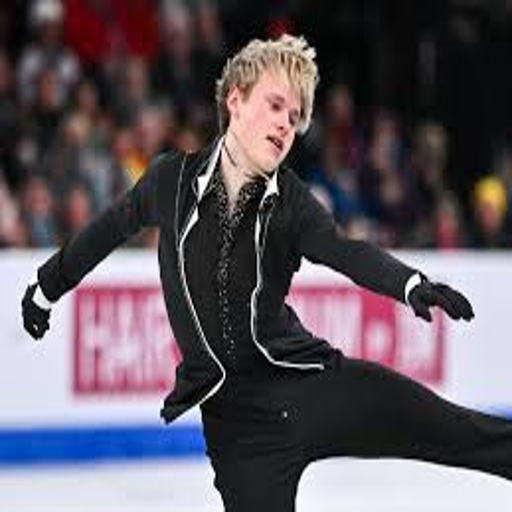

In [21]:
display(day_img)

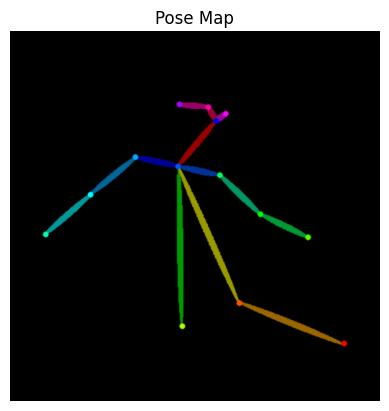

In [22]:
# ✅ STEP 4: Generate depth map from day image
open_pose = OpenposeDetector.from_pretrained("lllyasviel/Annotators")

image = open_pose(day_img, detect_resolution=512, image_resolution=1024)
image = np.array(image)[:, :, ::-1]
image = Image.fromarray(np.uint8(image))


# Optional: show depth map
plt.imshow(image)
plt.title("Pose Map")
plt.axis("off")
plt.show()



In [23]:
# ✅ STEP 5: Load T2I-Adapter (pose) + Stable Diffusion XL
# load adapter

adapter = T2IAdapter.from_pretrained("TencentARC/t2i-adapter-openpose-sdxl-1.0", torch_dtype=torch.float16).to("cuda")

# load euler_a scheduler
model_id  = 'stabilityai/stable-diffusion-xl-base-1.0'
euler_a   = EulerAncestralDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
vae       = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe      = StableDiffusionXLAdapterPipeline.from_pretrained(
              model_id, vae=vae, adapter=adapter, scheduler=euler_a, torch_dtype=torch.float16, variant="fp16",
                ).to("cuda")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [24]:
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("✅ xformers enabled successfully!")
except Exception as e:
    print(f"❌ Could not enable xformers: {e}")

✅ xformers enabled successfully!


In [16]:
# Manually delete models/pipes
# del pipe
# del adapter
# del day_img

# # Run garbage collector
# import gc
# gc.collect()

# # Then clear CUDA cache again
# torch.cuda.empty_cache()
# torch.cuda.ipc_collect()

In [33]:
# # ✅ STEP 6: Define prompt to transform day → night
prompt = "A dancing panda, 4k photo, highly detailed"
negative_prompt = "anime, cartoon, graphic, text, painting, crayon, graphite, abstract, glitch, deformed, mutated, ugly, disfigured, deformed hand digits"

  0%|          | 0/30 [00:00<?, ?it/s]

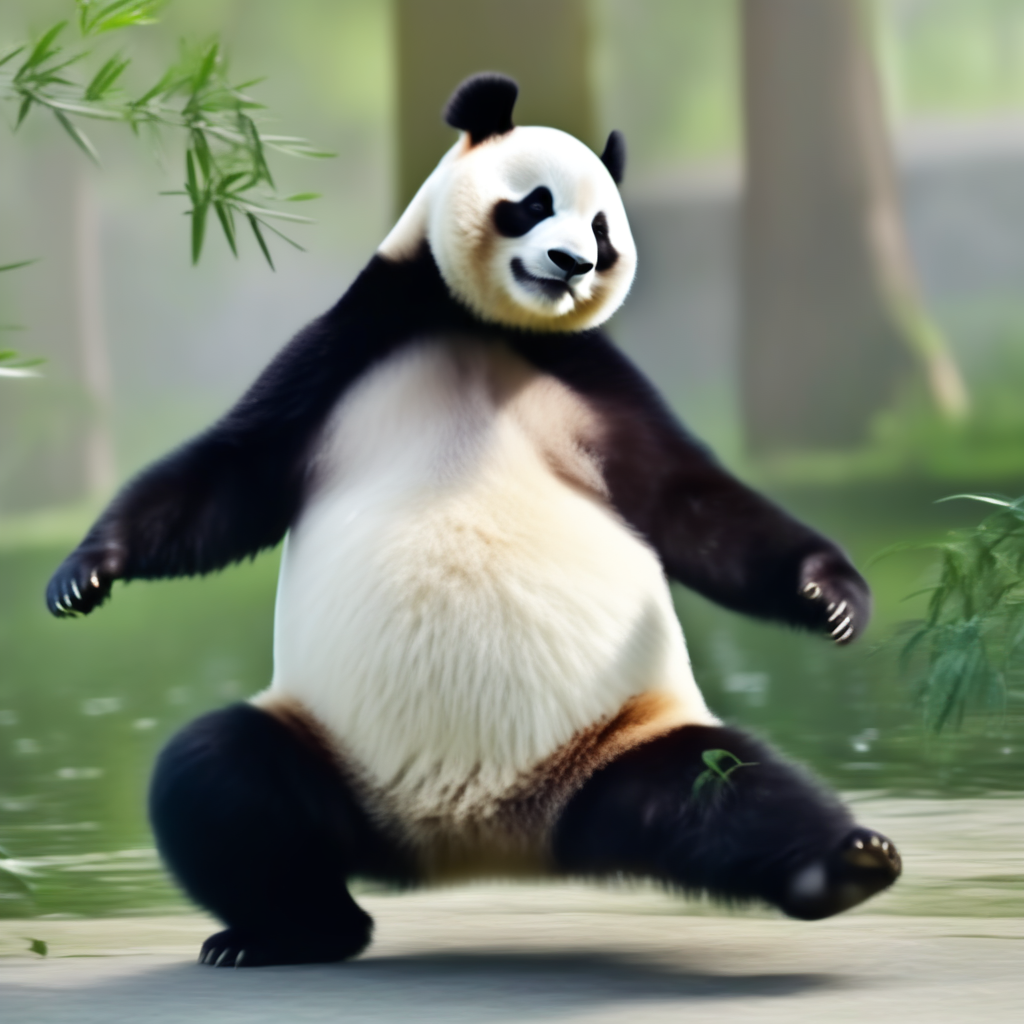

In [34]:
# ✅ STEP 7: Run generation

output = pipe(
  prompt=prompt,
  negative_prompt=negative_prompt,
  image=image,
  num_inference_steps=30,
  adapter_conditioning_scale=1,
  guidance_scale=7.5
).images[0]

display(output)